# Evaluation of all models. LR, SVC, KNN, DTC, SGDC, NB, RF, and DeepLearning

In [8]:
# combined_evaluation.py

# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import pickle

# TensorFlow Keras for Deep Learning Model
from tensorflow.keras.utils import to_categorical

# Scikit-learn for Machine Learning Models
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 평가 지표 반올림 함수 정의
def round_up_metric_results(results):
    return list(map(lambda el: round(el, 3), results))

# 테스트 데이터 로드 함수
def load_test_data(test_csv_path, scaler_path):
    df = pd.read_csv(test_csv_path)

    # 레이블 인코딩
    df.loc[df["label"] == "down", "label"] = 0
    df.loc[df["label"] == "up", "label"] = 1

    # 스케일러 로드 및 변환
    with open(scaler_path, "rb") as f:
        sc = pickle.load(f)
    X = df.drop("label", axis=1)
    X_scaled = pd.DataFrame(sc.transform(X))

    y = df["label"].astype(int)
    y_cat = to_categorical(y)

    return X_scaled, y, y_cat

# 테스트 데이터 로드
test_csv_path = "./test.csv"
scaler_path = "./model/input_scaler.pkl"  # 딥러닝과 머신러닝 모델 모두 호환되는 스케일러 사용
X_test, y_test, y_test_cat = load_test_data(test_csv_path, scaler_path)

# 딥러닝 모델 로드
with open("./model/squat_dp.pkl", "rb") as f:
    deep_learning_model = pickle.load(f)

# 머신러닝 모델 로드
machine_learning_models = {}
with open("./model/LR_model.pkl", "rb") as f:
    machine_learning_models["Logistic Regression"] = pickle.load(f)
with open("./model/SGDC_model.pkl", "rb") as f:
    machine_learning_models["SGD Classifier"] = pickle.load(f)

# 결과 저장을 위한 리스트 초기화
model_names = ["Deep Learning"] + list(machine_learning_models.keys())
precision_scores = []
recall_scores = []
f1_scores = []
confusion_matrices = []

# 딥러닝 모델 평가
dl_predict_prob = deep_learning_model.predict(X_test, verbose=False)
dl_predictions = np.argmax(dl_predict_prob, axis=1)

dl_cm = confusion_matrix(y_test, dl_predictions, labels=[0, 1])
dl_p_score, dl_r_score, dl_f_score, _ = precision_recall_fscore_support(
    y_test, dl_predictions, labels=[0, 1]
)

precision_scores.append(round_up_metric_results(dl_p_score))
recall_scores.append(round_up_metric_results(dl_r_score))
f1_scores.append(round_up_metric_results(dl_f_score))
confusion_matrices.append(dl_cm)

# 머신러닝 모델 평가
for model_name, model in machine_learning_models.items():
    ml_predictions = model.predict(X_test)

    ml_cm = confusion_matrix(y_test, ml_predictions, labels=[0, 1])
    ml_p_score, ml_r_score, ml_f_score, _ = precision_recall_fscore_support(
        y_test, ml_predictions, labels=[0, 1]
    )

    precision_scores.append(round_up_metric_results(ml_p_score))
    recall_scores.append(round_up_metric_results(ml_r_score))
    f1_scores.append(round_up_metric_results(ml_f_score))
    confusion_matrices.append(ml_cm)

# 결과를 데이터프레임으로 정리
results = {
    "Model": model_names,
    "Precision Score": precision_scores,
    "Recall Score": recall_scores,
    "F1 Score": f1_scores,
    "Confusion Matrix": confusion_matrices,
}

results_df = pd.DataFrame(results)
print(results_df)


                 Model Precision Score    Recall Score        F1 Score  \
0        Deep Learning  [0.995, 0.998]  [0.998, 0.995]  [0.997, 0.996]   
1  Logistic Regression  [0.993, 0.998]  [0.998, 0.993]  [0.995, 0.995]   
2       SGD Classifier  [0.993, 0.998]  [0.998, 0.993]  [0.995, 0.995]   

       Confusion Matrix  
0  [[429, 1], [2, 421]]  
1  [[429, 1], [3, 420]]  
2  [[429, 1], [3, 420]]  


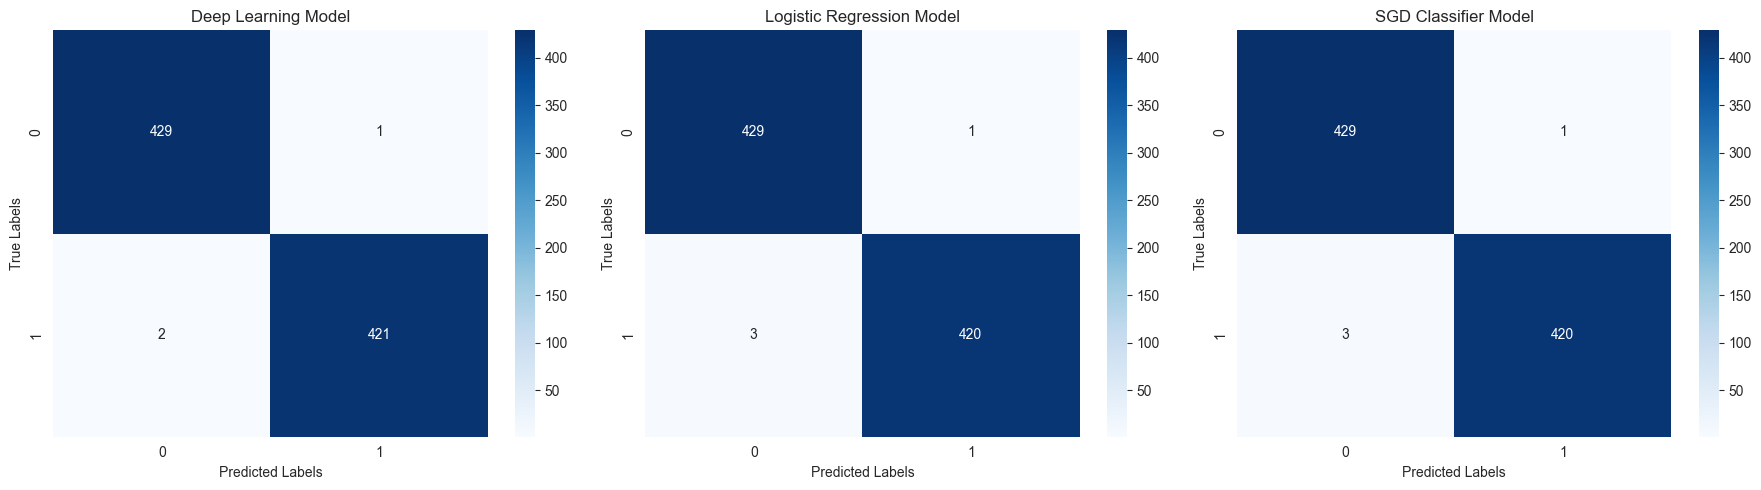

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# 혼동 행렬 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model_name, cm) in enumerate(zip(results['Model'], results['Confusion Matrix'])):
    sns.heatmap(cm, annot=True, fmt='g', ax=axes[idx], cmap='Blues')
    axes[idx].set_title(f'{model_name} Model')
    axes[idx].set_xlabel('Predicted Labels')
    axes[idx].set_ylabel('True Labels')

plt.tight_layout()
plt.show()
